In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

def load_data_from_folders(base_dir, activity_folders):
    column_names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    all_data = pd.DataFrame()
    label_encoder = LabelEncoder()
    scaler = StandardScaler()
    
    # Load data from each folder
    for activity in activity_folders:
        folder_path = os.path.join(base_dir, activity)
        files = [f for f in os.listdir(folder_path) if not os.path.isdir(os.path.join(folder_path, f))]
        activity_data = pd.DataFrame()
        
        for file in files:
            file_path = os.path.join(folder_path, file)
            try:
                # Ensure data does not include any non-numeric values or unexpected strings
                temp_df = pd.read_csv(file_path, comment='#', header=None, names=column_names, on_bad_lines='skip')
                temp_df = temp_df.dropna()  # Drop any rows with NaN values
                temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
                temp_df['label'] = activity
                activity_data = pd.concat([activity_data, temp_df], ignore_index=True)
            except pd.errors.ParserError as e:
                print(f"Skipping file {file} due to errors: {e}")
        
        all_data = pd.concat([all_data, activity_data], ignore_index=True)

    # Encode labels
    all_data['label'] = label_encoder.fit_transform(all_data['label'])
    
    # Check for non-numeric values
    feature_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    all_data[feature_columns] = all_data[feature_columns].apply(pd.to_numeric, errors='coerce')  # Coerce any remaining non-numeric entries to NaN, and then drop them
    all_data = all_data.dropna(subset=feature_columns)
    
    # Normalize features
    all_data[feature_columns] = scaler.fit_transform(all_data[feature_columns])
    
    return all_data, label_encoder.classes_




# Create sequences from the data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    feature_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    for i in range(len(data) - seq_length):
        seq = data[feature_columns].iloc[i:i + seq_length].values
        label = data['label'].iloc[i + seq_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Parameters
base_dir = '/Users/habib/Desktop/DL/data/Activity-Recognition-system-based-on-Multisensor-data-fusion-(AReM)'
activity_folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
seq_length = 50

# Load and preprocess data
data, classes = load_data_from_folders(base_dir, activity_folders)

# Generate sequences
sequences, labels = create_sequences(data, seq_length)

# Split data and convert to tensors
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 20% of the entire dataset for validation

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

print(train_loader)


/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_38875/292318630.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_38875/292318630.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_38875/292318630.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_38875/292318630.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use Data

In [2]:
print("x/y_train shape ", X_train.shape, y_train.shape)
print("x/y_validation shape ", X_val.shape, y_val.shape)
print("x/y_validation shape ", X_test.shape, y_test.shape)

x/y_train shape  torch.Size([25023, 50, 6]) torch.Size([25023])
x/y_validation shape  torch.Size([8342, 50, 6]) torch.Size([8342])
x/y_validation shape  torch.Size([8342, 50, 6]) torch.Size([8342])


In [4]:
import math

class TimeSeriesPatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim, input_timesteps):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels

        # Calculate the number of patches, adjusting for padding if necessary
        # Ceiling division to account for padding
        self.num_patches = -(-input_timesteps // patch_size)
        self.padding = (
            self.num_patches * patch_size
        ) - input_timesteps  # Calculate padding length

        self.conv_layer = nn.Conv1d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

        self.class_token_embeddings = nn.Parameter(
            torch.randn((1, 1, embedding_dim), requires_grad=True)
        )
        self.position_embeddings = PositionalEncoding(embedding_dim, dropout=0.1, max_len=input_timesteps)

    def forward(self, x):
        # Pad the input sequence if necessary
        if self.padding > 0:
            x = nn.functional.pad(x, (0, 0, 0, self.padding))  # Pad the second to last dimension, which is input_timesteps

        # We use a Conv1d layer to generate the patch embeddings
        x = x.permute(0, 2, 1)  # (batch, features, timesteps)
        conv_output = self.conv_layer(x)
        conv_output = conv_output.permute(0, 2, 1)  # (batch, timesteps, features)

        batch_size = x.shape[0]
        class_tokens = self.class_token_embeddings.expand(batch_size, -1, -1)
        output = torch.cat((class_tokens, conv_output), dim=1)

        output = self.position_embeddings(output)

        return output


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

    def pos_encoding(self, q_len, d_model, normalize=True):
        pe = torch.zeros(q_len, d_model)
        position = torch.arange(0, q_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        if normalize:
            pe = pe - pe.mean()
            pe = pe / (pe.std() * 10)
        return pe

    def forward(self, x):
        x = x + self.pos_encoding(q_len = x.size(1), d_model = x.size(2))
        return self.dropout(x)

In [5]:
random_instances, random_labels = next(iter(train_loader))
random_instance = random_instances[0]

BATCH_SIZE = random_instances.shape[0]
TIMESTEPS = random_instance.shape[0]
CHANNELS = random_instance.shape[1]
PATCH_SIZE = 8

patch_embedding_layer = TimeSeriesPatchEmbeddingLayer(
    in_channels=CHANNELS,
    patch_size=PATCH_SIZE,
    embedding_dim=CHANNELS * PATCH_SIZE,
    input_timesteps=TIMESTEPS,
)

patch_embeddings = patch_embedding_layer(random_instances)
patch_embeddings.shape


torch.Size([64, 8, 48])

In [6]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_timesteps, in_channels, patch_size, embedding_dim, num_transformer_layers=6, num_heads=8, dim_feedforward=128, dropout=0.1, num_classes=2):
        super().__init__()

        # Embedding layer
        self.patch_embedding = TimeSeriesPatchEmbeddingLayer(in_channels, patch_size, embedding_dim, input_timesteps)

        # Calculate the number of patches
        self.num_patches = -(-input_timesteps // patch_size)

        # Transformer Encoder
        # Setting batch_first=True to accommodate inputs with batch dimension first
        encoder_layers = TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer=encoder_layers, num_layers=num_transformer_layers)

        # Feedforward layer
        self.ff_layer = nn.Linear(embedding_dim, dim_feedforward)
        # Classifier Head
        self.classifier = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        # x shape: (batch_size, in_channels, input_timesteps)

        # Get patch embeddings
        x = self.patch_embedding(x)  # Output shape: (batch_size, num_patches + 1, embedding_dim)

        # Apply Transformer Encoder with batch first
        x = self.transformer_encoder(x)  # Output shape: (batch_size, num_patches + 1, embedding_dim)

        # Use the output corresponding to the class token for classification
        class_token_output = x[:, 0, :]  # Select the class token for each item in the batch

        # Feedforward layer
        x = self.ff_layer(class_token_output)

        # Classifier head
        output = self.classifier(x)  # Output shape: (batch_size, num_classes)

        return output


In [7]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=8,
    embedding_dim=32,
    num_transformer_layers=4,
    num_heads=4,
    dim_feedforward=128,
    dropout=0.2,
    num_classes=7,
).to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler to reduce the learning rate by the specified step size and factor (gamma) every step_size epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)


In [8]:
# Model, loss function, and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Number of epochs
n_epochs = 10

# Initialize variables for tracking the best model
best_validation_acc = 0.0
best_model_path = 'best_model_v2.pth'

for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    train_losses = []
    train_correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients

        predictions = model(inputs)  # Forward pass
        loss = criterion(predictions, labels)  # Calculate loss

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        train_losses.append(loss.item())

        # Count the number of correct predictions
        train_correct += (predictions.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = np.mean(train_losses)
    train_acc = train_correct / total

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        validation_losses = []
        validation_correct = 0
        total_val = 0

        for inputs, labels in val_loader:
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            validation_losses.append(loss.item())

            validation_correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

        validation_loss = np.mean(validation_losses)
        validation_acc = validation_correct / total_val

    # Check if this is the best model so far
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch {epoch+1}: New best model saved with validation accuracy: {validation_acc:.4f}')

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.4f}')

# Loading the best model
model.load_state_dict(torch.load(best_model_path))
print('Loaded best model for testing or further use.')

Epoch 1: New best model saved with validation accuracy: 0.8802
Epoch 1, Train Loss: 0.4701, Train Acc: 0.8188, Val Loss: 0.2906, Val Acc: 0.8802
Epoch 2: New best model saved with validation accuracy: 0.9045
Epoch 2, Train Loss: 0.3064, Train Acc: 0.8759, Val Loss: 0.2375, Val Acc: 0.9045
Epoch 3: New best model saved with validation accuracy: 0.9114
Epoch 3, Train Loss: 0.2709, Train Acc: 0.8900, Val Loss: 0.2239, Val Acc: 0.9114
Epoch 4: New best model saved with validation accuracy: 0.9120
Epoch 4, Train Loss: 0.2488, Train Acc: 0.8996, Val Loss: 0.2054, Val Acc: 0.9120
Epoch 5: New best model saved with validation accuracy: 0.9292
Epoch 5, Train Loss: 0.2278, Train Acc: 0.9077, Val Loss: 0.1779, Val Acc: 0.9292
Epoch 6: New best model saved with validation accuracy: 0.9359
Epoch 6, Train Loss: 0.2026, Train Acc: 0.9216, Val Loss: 0.1616, Val Acc: 0.9359
Epoch 7, Train Loss: 0.1839, Train Acc: 0.9262, Val Loss: 0.1600, Val Acc: 0.9348
Epoch 8: New best model saved with validation ac

In [11]:
# Prediction
model.eval()
with torch.no_grad():
    Y_pred_prob = model(X_test)

Y_pred = Y_pred_prob.argmax(1)

print(classification_report(y_test, Y_pred))
confusion = confusion_matrix(y_test, Y_pred)
print(f"Confusion matrix:\n{confusion}")

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       704
           1       0.97      0.94      0.95       483
           2       0.99      1.00      0.99      1467
           3       0.97      0.99      0.98      1381
           4       0.91      0.93      0.92      1478
           5       0.96      0.94      0.95      1401
           6       1.00      0.99      1.00      1428

    accuracy                           0.97      8342
   macro avg       0.97      0.96      0.97      8342
weighted avg       0.97      0.97      0.97      8342

Confusion matrix:
[[ 682    2    0    0   20    0    0]
 [   7  453    0    0   23    0    0]
 [   0    2 1462    0    0    0    3]
 [   0    0    0 1368   13    0    0]
 [  15    9    0   23 1371   60    0]
 [   1    0    0   17   73 1310    0]
 [   0    0   11    0    0    0 1417]]


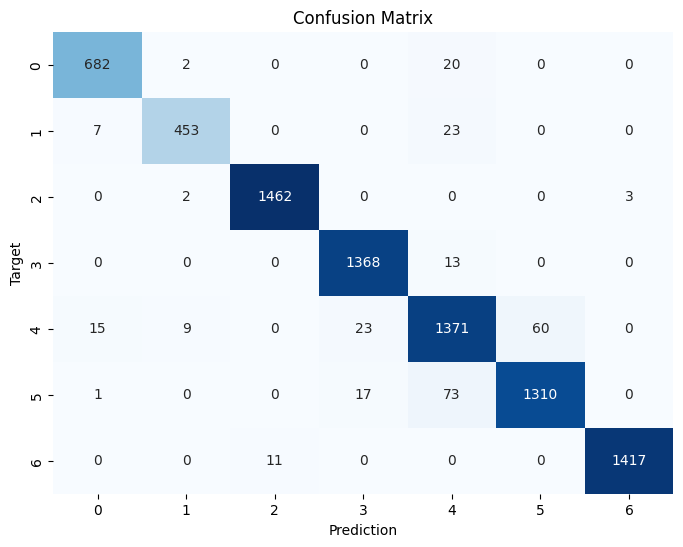

In [12]:
# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title("Confusion Matrix")
plt.show()

In [1]:
def time_shift(sample, max_shift):
    """
    Perform time-based augmentation by randomly shifting the time axis of the input sample.
    
    Args:
    - sample (ndarray): Input sample to be augmented.
    - max_shift (int): Maximum number of time steps to shift the sample.
    
    Returns:
    - augmented_sample (ndarray): Augmented sample with the time shift applied.
    """
    shift = np.random.randint(-max_shift, max_shift + 1)
    if shift >= 0:
        augmented_sample = np.pad(sample[:-shift], ((shift, 0), (0, 0)), mode='constant')
    else:
        augmented_sample = np.pad(sample[-shift:], ((0, -shift), (0, 0)), mode='constant')
    return augmented_sample


In [2]:
def add_noise(sample, noise_level):
    """
    Add Gaussian noise to the input sample.
    
    Args:
    - sample (ndarray): Input sample to which noise will be added.
    - noise_level (float): Standard deviation of the Gaussian noise.
    
    Returns:
    - noisy_sample (ndarray): Sample with noise added.
    """
    noise = np.random.normal(scale=noise_level, size=sample.shape)
    noisy_sample = sample + noise
    return noisy_sample


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os

def load_data_from_folders(base_dir, activity_folders):
    column_names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    all_data = pd.DataFrame()
    label_encoder = LabelEncoder()
    scaler = StandardScaler()
    
    # Load data from each folder
    for activity in activity_folders:
        folder_path = os.path.join(base_dir, activity)
        files = [f for f in os.listdir(folder_path) if not os.path.isdir(os.path.join(folder_path, f))]
        activity_data = pd.DataFrame()
        
        for file in files:
            file_path = os.path.join(folder_path, file)
            try:
                # Ensure data does not include any non-numeric values or unexpected strings
                temp_df = pd.read_csv(file_path, comment='#', header=None, names=column_names, on_bad_lines='skip')
                temp_df = temp_df.dropna()  # Drop any rows with NaN values
                temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
                temp_df['label'] = activity
                activity_data = pd.concat([activity_data, temp_df], ignore_index=True)
            except pd.errors.ParserError as e:
                print(f"Skipping file {file} due to errors: {e}")
        
        all_data = pd.concat([all_data, activity_data], ignore_index=True)

    # Encode labels
    all_data['label'] = label_encoder.fit_transform(all_data['label'])
    
    # Check for non-numeric values
    feature_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    all_data[feature_columns] = all_data[feature_columns].apply(pd.to_numeric, errors='coerce')  # Coerce any remaining non-numeric entries to NaN, and then drop them
    all_data = all_data.dropna(subset=feature_columns)
    
    # Normalize features
    all_data[feature_columns] = scaler.fit_transform(all_data[feature_columns])
    
    return all_data, label_encoder.classes_

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    feature_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    for i in range(len(data) - seq_length):
        seq = data[feature_columns].iloc[i:i + seq_length].values
        label = data['label'].iloc[i + seq_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

def augment_data(samples, target_length):
    augmented_samples = []
    for sample in samples:
        augmented_sample = sample.copy()  # Make a copy to avoid modifying the original data
        augmented_sample = time_shift(augmented_sample, max_shift=5)  # Example: Maximum shift of 5 time steps
        augmented_sample = add_noise(augmented_sample, noise_level=0.1)  # Example: Add Gaussian noise with standard deviation 0.1
        
        # Pad or crop the sample to the target length
        if augmented_sample.shape[0] < target_length:
            pad_width = ((0, target_length - augmented_sample.shape[0]), (0, 0))
            augmented_sample = np.pad(augmented_sample, pad_width, mode='constant', constant_values=0)
        elif augmented_sample.shape[0] > target_length:
            augmented_sample = augmented_sample[:target_length]
        
        augmented_samples.append(augmented_sample)
    
    return np.array(augmented_samples)

# Parameters
base_dir = '/Users/habib/Desktop/University/Spring-2024/CS73389H/Project/activity+recognition+system+based+on+multisensor+data+fusion+arem'
activity_folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
seq_length = 50
target_length = 50  # Length to which augmented samples will be padded or cropped

# Load and preprocess data
data, classes = load_data_from_folders(base_dir, activity_folders)

# Generate sequences
sequences, labels = create_sequences(data, seq_length)

# Split data into train, val, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 20% of the entire dataset for validation

# Augment training data
X_train_augmented = augment_data(X_train, target_length=target_length)
X_train = np.concatenate([X_train, X_train_augmented], axis=0)
y_train = np.concatenate([y_train, y_train], axis=0)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)


/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_30691/2959485972.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_30691/2959485972.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_df.applymap(lambda x: isinstance(x, str)).any(axis=1)]  # Remove any rows that contain strings
/var/folders/3c/c516_p2j2_xfd6ky_lxkpyhw0000gn/T/ipykernel_30691/2959485972.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  temp_df = temp_df[~temp_

In [9]:
# Model, loss function, and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Number of epochs
n_epochs = 10

# Initialize variables for tracking the best model
best_validation_acc = 0.0
best_model_path = 'best_model_v2.pth'

for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    train_losses = []
    train_correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients

        predictions = model(inputs)  # Forward pass
        loss = criterion(predictions, labels)  # Calculate loss

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        train_losses.append(loss.item())

        # Count the number of correct predictions
        train_correct += (predictions.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = np.mean(train_losses)
    train_acc = train_correct / total

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        validation_losses = []
        validation_correct = 0
        total_val = 0

        for inputs, labels in val_loader:
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            validation_losses.append(loss.item())

            validation_correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

        validation_loss = np.mean(validation_losses)
        validation_acc = validation_correct / total_val

    # Check if this is the best model so far
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch {epoch+1}: New best model saved with validation accuracy: {validation_acc:.4f}')

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.4f}')

# Loading the best model
model.load_state_dict(torch.load(best_model_path))
print('Loaded best model for testing or further use.')

Epoch 1: New best model saved with validation accuracy: 0.8896
Epoch 1, Train Loss: 0.5063, Train Acc: 0.8008, Val Loss: 0.2591, Val Acc: 0.8896
Epoch 2: New best model saved with validation accuracy: 0.9102
Epoch 2, Train Loss: 0.3634, Train Acc: 0.8523, Val Loss: 0.2193, Val Acc: 0.9102
Epoch 3: New best model saved with validation accuracy: 0.9343
Epoch 3, Train Loss: 0.3123, Train Acc: 0.8718, Val Loss: 0.1608, Val Acc: 0.9343
Epoch 4: New best model saved with validation accuracy: 0.9396
Epoch 4, Train Loss: 0.2751, Train Acc: 0.8855, Val Loss: 0.1444, Val Acc: 0.9396
Epoch 5: New best model saved with validation accuracy: 0.9596
Epoch 5, Train Loss: 0.2508, Train Acc: 0.8977, Val Loss: 0.1042, Val Acc: 0.9596
Epoch 6: New best model saved with validation accuracy: 0.9663
Epoch 6, Train Loss: 0.2307, Train Acc: 0.9064, Val Loss: 0.0890, Val Acc: 0.9663
Epoch 7: New best model saved with validation accuracy: 0.9761
Epoch 7, Train Loss: 0.2181, Train Acc: 0.9120, Val Loss: 0.0646, V

In [10]:
# Prediction
model.eval()
with torch.no_grad():
    Y_pred_prob = model(X_test)

Y_pred = Y_pred_prob.argmax(1)

print(classification_report(y_test, Y_pred))
confusion = confusion_matrix(y_test, Y_pred)
print(f"Confusion matrix:\n{confusion}")

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       704
           1       0.99      0.95      0.97       483
           2       1.00      1.00      1.00      1467
           3       0.99      1.00      1.00      1381
           4       0.95      0.99      0.97      1478
           5       0.99      0.97      0.98      1401
           6       1.00      1.00      1.00      1428

    accuracy                           0.99      8342
   macro avg       0.99      0.98      0.98      8342
weighted avg       0.99      0.99      0.99      8342

Confusion matrix:
[[ 680    0    0    0   24    0    0]
 [   7  457    0    0   19    0    0]
 [   0    2 1465    0    0    0    0]
 [   0    0    0 1381    0    0    0]
 [   3    2    0    4 1460    9    0]
 [   0    0    0    4   41 1356    0]
 [   0    0    1    0    0    1 1426]]


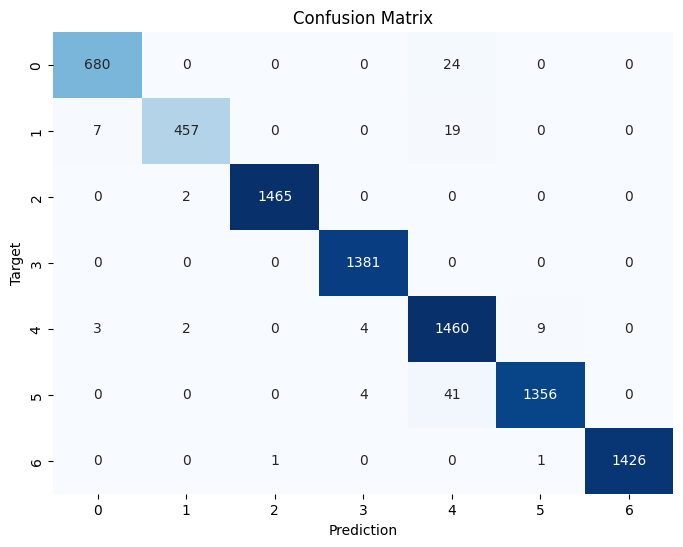

In [11]:
# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title("Confusion Matrix")
plt.show()